In [1]:
DEBUG = False
MODEL_DEBUG = False
MODEL_IMPROVE_DEBUG = False
GPU_COUNT = 2

### References
<ul>
	<li>Adam, A. (2018) Early Stopping and its Faults, Early Stopping and its Faults. Available at: https://alexadam.ca/2018/08/03/early-stopping/ (Accessed: 25 October 2022).  </li>
	<li>Burnham, K.P. and Anderson, D.R. (2010) Model selection and multimodel inference: a practical information-theoretic approach. 2. ed. New York, NY: Springer.  </li>
	<li>Dai, Z. et al. (2021) ‘CoAtNet: Marrying Convolution and Attention for All Data Sizes’. arXiv. Available at: http://arxiv.org/abs/2106.04803 (Accessed: 13 November 2022).  </li>
	<li>He, K. et al. (2015) ‘Deep Residual Learning for Image Recognition’. arXiv. Available at: http://arxiv.org/abs/1512.03385 (Accessed: 13 November 2022).  </li>
	<li>Howard, A.G. et al. (2017) ‘MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications’. arXiv. Available at: http://arxiv.org/abs/1704.04861 (Accessed: 13 November 2022).  </li>
	<li>Hu, J. et al. (2019) ‘Squeeze-and-Excitation Networks’. arXiv. Available at: http://arxiv.org/abs/1709.01507 (Accessed: 13 November 2022).  </li>
	<li>Shorten, C. and Khoshgoftaar, T.M. (2019) ‘A survey on Image Data Augmentation for Deep Learning’, Journal of Big Data, 6(1), p. 60. Available at: https://doi.org/10.1186/s40537-019-0197-0.  </li>
	<li>Valueva, M.V. et al. (2020) ‘Application of the residue number system to reduce hardware costs of the convolutional neural network implementation’, Mathematics and Computers in Simulation, 177, pp. 232–243. Available at: https://doi.org/10.1016/j.matcom.2020.04.031.  </li>
	<li>Xiao, H., Rasul, K. and Vollgraf, R. (2017) ‘Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms’. arXiv. Available at: http://arxiv.org/abs/1708.07747 (Accessed: 19 October 2022).  </li>
	<li>Zhong, Z. et al. (2017) ‘Random Erasing Data Augmentation’. arXiv. Available at: http://arxiv.org/abs/1708.04896 (Accessed: 24 October 2022).  </li>
</ul>

<img src="https://static.vecteezy.com/system/resources/previews/000/108/974/original/vector-fashion-girl.jpg" width="700px" />

## Fashion-MNIST Classification

> Can we develop a model that performs well on the Fashion-MNIST dataset?

### Context
Fashion-MNIST is a dataset from Zalando research, comprising of <code>28 x 28</code> grayscale images of a total fo <code>70000</code> fashion products from 10 categories. The intent of this dataset is to serve as a replacement for the MNIST dataset for testing and benchmarking machine learning and deep learning models (Xiao, Rasul and Vollgraf, 2017).

The dataset is based on images from Zalando's assortment. Each original image of <code>762 x 1000</code> in JPEG format was converted to PNG, resized, and then converted to grayscale.

### Objectives
<ol>
	<li>To explore and understand the dataset</li>
	<li>Understand the effects of different data augmentation techniques on the performance of the model</li>
	<li>Develop and experiment with models in order to rival state-of-the-art (SOTA) benchmark scores</li>
</ol>

## Importing libraries
We import the necessary libraries for the notebook to run below.

In [2]:
!pip install -q einops
!pip install -q pandas
!pip install -q seaborn
!pip install -q matplotlib
!pip install -q opencv-python
!pip install -q scikit-learn

In [3]:
import math
# if not DEBUG:
# 	from MulticoreTSNE import MulticoreTSNE as TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set('notebook')
from PIL import Image

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import InterpolationMode
import os

from einops import rearrange
from einops.layers.torch import Rearrange


We see the seed such that the notebook results in reproducible results when run. 

We also set the device to CUDA to enable torch to use our GPU.

In [4]:
seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# When running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
# Set a fixed value for the hash seed
os.environ['PYTHONHASHSEED'] = str(seed)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)
if device != torch.device('cuda'):
    print('using cpu, exiting')
    assert False

Device available now: cuda


## Utility Functions
Below we define some utility functions that will ease and help us with our analysis.

In [5]:
def loc_data(data, loc):
	datacopy = copy.deepcopy(data)
	arr = np.array(datacopy.loc[loc].drop('label'))
	label = datacopy.loc[loc]['label']
	root = int(len(arr) ** 0.5)
	arr.resize((root, root))
	return label, arr

def imshow(arr: list, label: list = None, grayscale=True, figsize=None):
	if label == None:
		label = [''] * len(arr)

	height = int(len(arr) ** 0.5)
	width = math.ceil(len(arr) / height)

	if figsize == None:
		fig = plt.figure()
	else:
		fig = plt.figure(figsize=figsize)
	for i in range(height):
		for j in range(width):
			ax = fig.add_subplot(height, width, i * height + j + 1)
			ax.grid(False)
			ax.set_xticks([])
			ax.set_yticks([])
			ax.imshow(arr[i * height + j], cmap='gray' if grayscale else '')
			ax.set_title(label[i * height + j])

def df_to_tensor(df, shape = (28, 28)):
	return torch.tensor(df.values.reshape((-1, *shape)), dtype=torch.float32)


def preprocess(df):
	return df.applymap(lambda x: x / 255)

def mse(t1, t2, shape=(28, 28)):
	loss = nn.MSELoss(reduction='none')
	loss_result = torch.sum(loss(t1, t2), dim=2)
	loss_result = torch.sum(loss_result, dim=2)
	loss_result = loss_result / np.prod([*shape])
	return loss_result

## Dataset
Let's take a look at the dataset. This dataset was retrieved from the original Fashion MNIST dataset found at <a href="https://arxiv.org/pdf/1708.07747v2.pdf">Paper Link</a>. 

<table>
	<tr>
		<th>
			Column Name
		</th>
		<th>
			Description
		</th>
	</tr>
	<tr>
		<td>
			label
		</td>
		<td>
			The true class of the image, represented as an integer ranging from 0 to 9<strong>*</strong>
		</td>
	</tr>
	<tr>
		<td>
			pixel 1<br/>...<br/>pixel 784
		</td>
		<td>
			Pixels representing the image, each pixel ranging from 0 to 255
		</td>
	</tr>
</table>

<strong>\*</strong>Each number represents a certain dress item
```
0 -> T-shirt/top
1 -> Trouser
2 -> Pullover
3 -> Dress
4 -> Coat
5 -> Sandal
6 -> Shirt
7 -> Sneaker
8 -> Bag
9 -> Ankle boot
```

In [6]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's take a look at the training dataset

In [7]:
train = pd.read_csv('data/fashion-mnist_train.csv')
train.shape

(60000, 785)

We observe that there are a total of <code>60000</code> rows and <code>785</code> columns, which is exactly what the original paper mentioned.

### Testing for missing values and invalid data
Let's try to identify if there are any missing values

In [8]:
train.isnull().sum().sum()

0

It appears <strong>no missing values are found</strong>. We will then check for any potential typos.
<ol>
	<li>Firstly, the label should only consist of values from 0 - 9</li>
	<li>Secondly, the pixel values should only fall in between and inclusive of 0 - 255</li>
</ol>

In [9]:
print('Minimum and Maximum values of labels:', train['label'].min(), "and", train['label'].max())
print("Number of values falling outside the range (0 - 255):",
	train.applymap(
		lambda x: x < 0 or x > 255 # True if out of range
	).sum().sum()
)

Minimum and Maximum values of labels: 0 and 9
Number of values falling outside the range (0 - 255): 0


We observe that the dataset seems to be properly cleaned, thus can proceed knowing that <strong>no sign of invalid or missing data have been found.</strong>

### Preprocessing
We'll convert the data such that the range <code>0 - 255</code> becomes <code>0 - 1</code>

In [10]:
train[train.columns[train.columns != 'label']] = preprocess(train[train.columns[train.columns != 'label']])

## Exploratory Data Analysis
In the EDA, we'll be attempting to complete the following set of objectives:

### EDA Objectives
<ol>
	<li>
		Is there any <strong>class imbalance</strong>
	</li>
	<li>
		What does the <strong>average image</strong> look like?
	</li>
	<li>
		Are there <strong>any outliers/anomalies</strong>?
	</li>
</ol>
Before we begin the EDA, we first need to remove a chunk of the training data to be used as validation dataset in order to avoid data leakage due to the decisions we make during EDA.

### Validation Dataset
Let's make our validation dataset. I decided that I will <strong>not be using cross validation during the modelling process</strong> due to the following reasons:
<ul>
	<li>Time taken to train models, especially if utilising <strong>computationally expensive layers, activation functions or architecture</strong></li>
	<li>Additionally due to the sheer size of the dataset, not only does this add to increased training time but also means there is enough data such that cross validation is not necessary</li>
</ul>

We'll use a validation size of <code>10000</code> to mimic the size of the test dataset. We'll also stratify on the <code>label</code> to ensure that the model we generalizes best across all 
the classes.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('label', axis=1), train['label'], test_size = 10000 / len(train), stratify=train['label'])
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (50000, 784)
X_val shape: (10000, 784)
y_train shape: (50000,)
y_val shape: (10000,)


We see that the data have been split correctly and now we can begin our EDA!

### Signs of class imbalance?
We'll first identify the situation with class imbalance

<AxesSubplot: xlabel='label', ylabel='Count'>

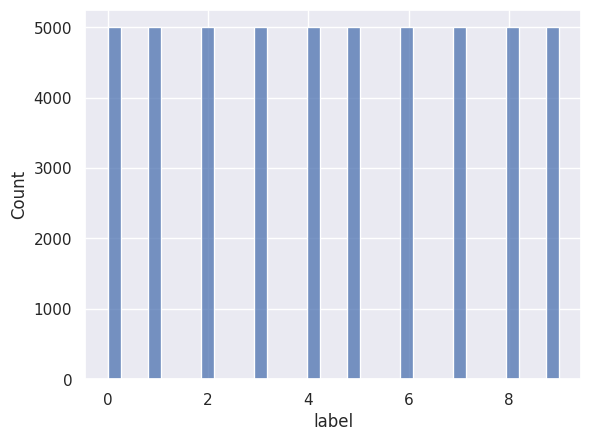

In [12]:
sns.histplot(y_train)

We observe the distribution of labels to be similar for all classes, reaching roughly a count of `5000`. Thus, there is no sign of class imbalance.

### What does the average image look like?
Let's take a look at a random sample of image each first.

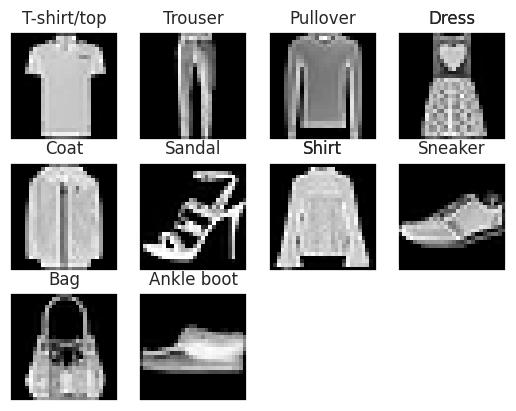

In [13]:
images = []
titles = []

for i in range(10):
	idx = random.sample(list(y_train[y_train == i].index), 1)
	images.append(X_train.loc[idx].values.reshape((28, 28)))
	titles.append(classes[y_train.loc[idx].values[0]])

imshow(images, titles)

We observe that sometimes, there appears to be certain images that are <strong>darker</strong> than others. This suggests that no form of normalization or scaling has been applied to the dataset. Let's take a look at the distribution of brightness to confirm this.

Text(0.5, 0, 'Average Brightness per Image')

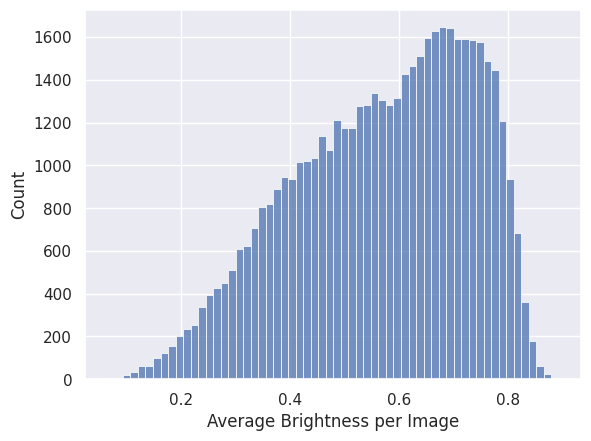

In [14]:
fig = plt.figure()
ax = fig.subplots()

# Note: we want to IGNORE the background of black, filtering by using x != 0
sns.histplot(X_train.apply(lambda x: x[x != 0].mean(), axis=1).values, ax=ax) 
ax.set_xlabel('Average Brightness per Image')

We observe:
<ol>
	<li>
		Most of the images are on the brighter side as we see a large bulk of the distribution going towards the right side.
	</li>
	<li>
		The distribution is skewed to the left, which suggests that we have a few images which are quite dark.
	</li>
</ol>


To find out what the average image looks like, we'll perform an average of the pixels across the different classes.

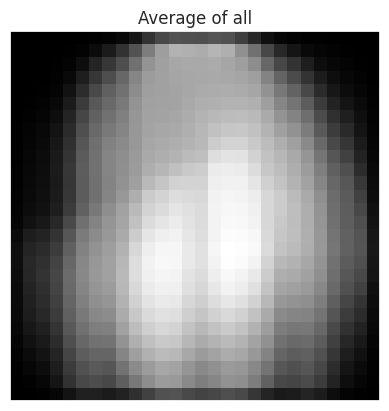

In [15]:
imshow([
	X_train.mean().apply(lambda x: x).values.reshape(28, 28)
], ['Average of all'])

We observe:
<ol>
	<li>The corners of the images are dark/black. This means there is likely no piece of clothing the spreads across the image.</li>
	<li>There is a bright circle-shape in the middle. This tells us most of these images are centered around in the middle</li>
	<li>An <strong>interesting note to point out</strong> is there seems to be some sort of darker 'bar' in the middle, separating the lightest parts of the image.</li>
	<li>
		This may be due to the presence of trousers in the dataset, as from previous images, we can see trousers appears to be the only apparel with such a contrasting stripe in the middle.
	</li>
</ol>

#### Average image among the classes
Next we'll split by the classes and find the average among them.

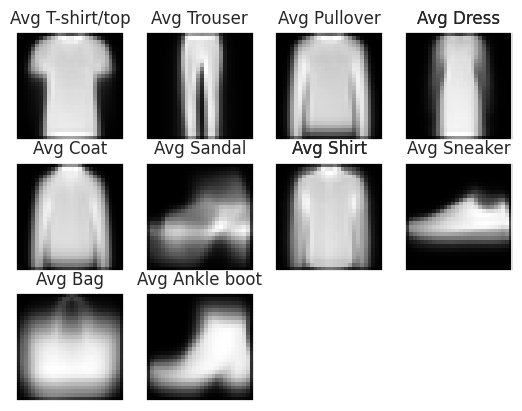

In [16]:
images = []
titles = []

for i in range(10):
	idx = random.sample(list(y_train[y_train == i].index), 1)
	images.append(X_train[y_train == i].mean().apply(lambda x: x).values.reshape(28, 28))
	titles.append(f'Avg {classes[y_train.loc[idx].values[0]]}')

imshow(images, titles)

We observe:
<ol>
	<li>Each type of apparel generally has the same shape</li>
	<li>The most <strong>spread out/least consistent</strong> class seems to be sandals, as seen from the opaque and thicker edges, where as the other types have sharper and lighter borders.</li>
</ol>


### Are there any outliers/anomalies?

We see from the average images, that the piece of clothing in the image are <strong>centered and upright</strong>, in that there are no sort of rotations going on.

As such, let's see if there may be any outlier images, such as rotations or anomaly white spots on the image.

We'll start by visualizing the dataset and seeing if outliers may exist. We can do this using <code>tSNE</code>.

In [17]:
if not DEBUG and False:
	tsne = TSNE(n_jobs=-1)
	TSNE()
	data_2d = tsne.fit_transform(X_train)

In [18]:
if not DEBUG and False:
	vis_x = data_2d[:, 0]
	vis_y = data_2d[:, 1]
	plt.scatter(vis_x, vis_y, c=y_train, cmap=plt.cm.get_cmap("jet", 10), marker='.')
	cbar = plt.colorbar(ticks=range(10))
	cbar.set_ticks([])
	for j, lab in enumerate(classes):
		cbar.ax.text(1.5, j, f'${lab}$', ha='left', va='center')

	cbar.ax.get_yaxis().labelpad = 15

	plt.clim(-0.5, 9.5)
	plt.title('Clustering Visualization with 2 components')
	plt.show()

TSNE produces an <strong>incredibly interesting visualization</strong>. We observe:
<ol>
	<li>
		There is a large breakoff of clusters at the top right. Taking a look at the classes we see that they are <code>Sneaker</code>, <code>Ankleboot</code> and <code>Sandal</code>, which are all types of footwear. 
	</li>
	<li>
		Within the footwear cluster, we recognise the classes are separated distinctly, with quite sharp edges. 
	</li>
	<li>
		The large cluster in the middle contains <code>pullover</code>, <code>dress</code>, <code>t-shirt</code> and <code>shirt</code>. This cluster seems to represent the upper body clothing.
	</li>
	<li>
		In this center cluster, the classes do not have distinct edges, but <strong>rather seem to mix and mingle together</strong>. This suggests that <code>TSNE with 2 components was unable</code> to separate these classes.
	</li>
	<li>
		Lastly, the cluster at the bottom left represents <code>bag</code>. We recognise a distinct split in the center of the cluster, suggesting that there are two types of bags.
	</li>
	<li>
		Looking at the top right cluster, we recognise some red and blue data points in the wrong cluster. This may suggest <strong>presence of outliers</strong>. Let's try to identify outliers and see how we can deal with them.
	</li>
</ol>

### Using Autoencoders to identify anomalies
The idea behind this is that we can use an autoencoder to some what <strong>compress</strong> the image, or restrict the image to its most important features. We'll train this autoencoder on minimising MSE with the original image, thus the autoencoder will learn to capture the more generic and most important features. 

Thus, after an anomaly has been passed through this autoencoder, we expect the MSE to be quite high as the anomaly image does not follow the general 'style' of the images in the dataset.

#### Defining the AutoEncoder architecture
We'll use a <strong>Convolutional Auto Encoder architecture</strong>, which is better able to extract features from images. This is because artificial neural networks do not account for proximity of each pixel to other pixels.

In [19]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, stride=2),
            nn.LeakyReLU(),

            nn.Conv2d(8, 16, 3, padding=1, stride=2),
            nn.LeakyReLU(),

            nn.Conv2d(16, 32, 3, padding=0, stride=2),
            nn.LeakyReLU(),
        )

        self.hidden = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(32 * 3 * 3, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32 * 3 * 3),
            nn.LeakyReLU(),
            nn.Unflatten(1, torch.Size([32, 3, 3]))
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, output_padding=0, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 8, 3, padding=1, output_padding=1, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 1, 3, padding=1, output_padding=1, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.hidden(x)
        x = self.decoder(x)

        return x

Now that we have set up the architecture, we can instantiate the model, optimizers and criterion. To train the autoencoder, we'll be using <strong>mean squared error</strong> loss.

$$MSE = \frac{1}{n ^ 2}\sum_{i = 0}^{n}\sum_{j = 0}^{n}(X_{ij} - \hat{X}_{ij}) ^ 2$$

where $X_{ij}$ is the true value of the pixel at the $\text{i'th}$ row and $\text{j'th}$ column and   
$\hat{X}_{ij}$ is the reconstructed value of the pixel at the $\text{i'th}$ row and $\text{j'th}$ column

This is because any pixel that <strong>stands out/is an anomaly</strong> will have a <strong>heavily influence</strong> on the loss <strong>due to the square in the loss function</strong>.

In [20]:
if not DEBUG:
	model = ConvAutoencoder()
	model = model.to(device)
	model = nn.DataParallel(model)
	optimizer = optim.Adam(model.parameters(), lr=1e-3 * GPU_COUNT ** 0.5)
	criterion = nn.MSELoss()

#### Loading the dataset
Next we need to load the dataset. In order to do this, below is a custom class that acts as a wrapper <strong>to convert a pandas dataframe to PyTorch tensors</strong>, such that we are able to load the dataset into the <code>DataLoader</code> class.

In [21]:
def to_prob_dist(labels: torch.tensor, size = 10):
	arr = np.full((len(labels), size), 0)
	for i, label in enumerate(labels):
		arr[i][int(label.item())] = 1
	return torch.tensor(arr, dtype=torch.float32)

class TorchDataset():
	def __init__(self, X, y, X_shape = (1, 28, 28), y_shape = (1, )):
		if (type(X) == torch.Tensor):
			self.x = X.to(device)
		else:
			self.x = df_to_tensor(X, X_shape).to(device)

		if (type(y) == torch.Tensor):
			self.y = y.to(device)
		else:
			self.y = df_to_tensor(y, y_shape)
			self.y = to_prob_dist(self.y).to(device)

		# Transform labels to probability distributions
	
	def __len__(self):
		return len(self.y)

	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]

In [22]:
train_loader = DataLoader(TorchDataset(X_train, y_train), batch_size=128 * GPU_COUNT, shuffle=True)

#### Training the Convolutional Auto Encoder
We can now train the auto encoder.

Epoch: 1 	Training Loss: 19.222086
Epoch: 2 	Training Loss: 6.344609
Epoch: 3 	Training Loss: 5.331772
Epoch: 4 	Training Loss: 4.787932
Epoch: 5 	Training Loss: 4.437863
Epoch: 6 	Training Loss: 4.164053
Epoch: 7 	Training Loss: 3.941652
Epoch: 8 	Training Loss: 3.767378
Epoch: 9 	Training Loss: 3.623511
Epoch: 10 	Training Loss: 3.497094
Epoch: 11 	Training Loss: 3.399757
Epoch: 12 	Training Loss: 3.323685
Epoch: 13 	Training Loss: 3.246674
Epoch: 14 	Training Loss: 3.175557
Epoch: 15 	Training Loss: 3.117938
Epoch: 16 	Training Loss: 3.073793
Epoch: 17 	Training Loss: 3.019614
Epoch: 18 	Training Loss: 2.987609
Epoch: 19 	Training Loss: 2.935097
Epoch: 20 	Training Loss: 2.898683
Epoch: 21 	Training Loss: 2.866947
Epoch: 22 	Training Loss: 2.835081
Epoch: 23 	Training Loss: 2.805380
Epoch: 24 	Training Loss: 2.780524
Epoch: 25 	Training Loss: 2.746455
Epoch: 26 	Training Loss: 2.723707
Epoch: 27 	Training Loss: 2.702307
Epoch: 28 	Training Loss: 2.674959
Epoch: 29 	Training Loss: 2.

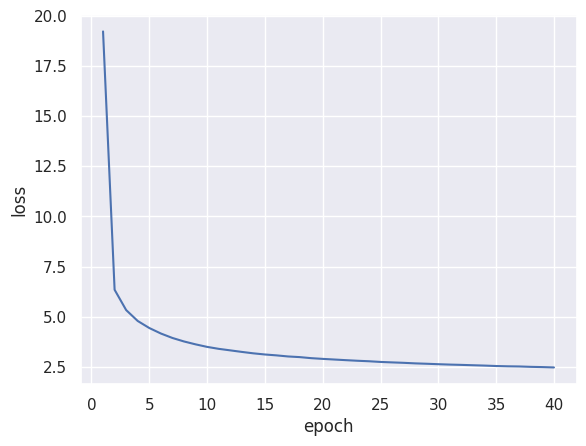

In [23]:
# number of epochs to train the model
if not DEBUG:
    n_epochs = 40

    track_loss = []

    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data
            images = images.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)
                
        # print avg training statistics 
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
        ))
        track_loss.append(train_loss)

    track_loss_df = pd.DataFrame({'epoch': np.arange(1, len(track_loss) + 1), 'loss': track_loss})
    sns.lineplot(track_loss_df, x = 'epoch', y = 'loss')

#### Interpretting the results
Let's take a look at how the autoencoder works

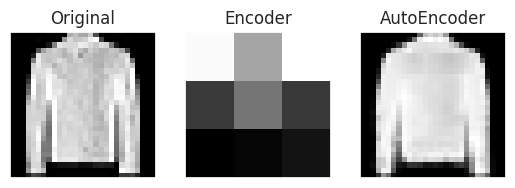

In [24]:
if not DEBUG:
	image = df_to_tensor(X_train.iloc[0], (1, 28, 28))
	image = image.to(device)
	encoder_output = model.module.encoder(image)
	model_output = model(image)
	imshow([image.cpu().numpy()[0, 0], encoder_output.cpu().detach().numpy()[0, 0], model_output.cpu().detach().numpy()[0, 0]], ['Original', 'Encoder', 'AutoEncoder'])

Now that we have a trained and working autoencoder, let's use it to identify any anomalies.

In [25]:
if not DEBUG:
	images = df_to_tensor(X_train, (1, 28, 28))
	images = images.to(device)
	outputs = model(images)

Let's take a look at the <code>99.95'th percentile</code>.

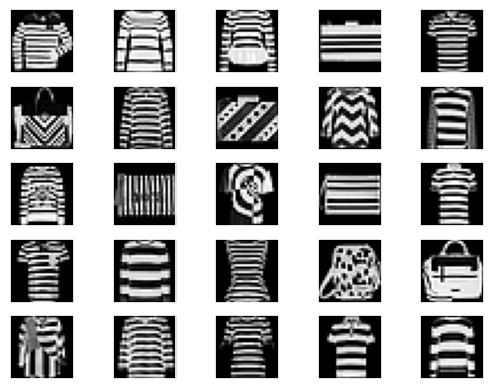

In [26]:
if not DEBUG:
	errors = mse(outputs, images).detach().cpu().numpy().flatten()
	error_boolean = errors > np.percentile(errors, 99.95)

	imshow(X_train.iloc[error_boolean].values.reshape((-1, 28, 28)))

We observe:
<ol>
	<li>
	</li>
</ol>

### Hypothesis: Footwear images only point to the left

From a view glimpses of footwear classes, we begin to recognise that it seems that all the images point to the left direction: in that the 'pointy' tip of the footwear is at the left and the heel is at the right.

Here, let's take a look at 36 randomly sampled footwear.

#### Random sampling

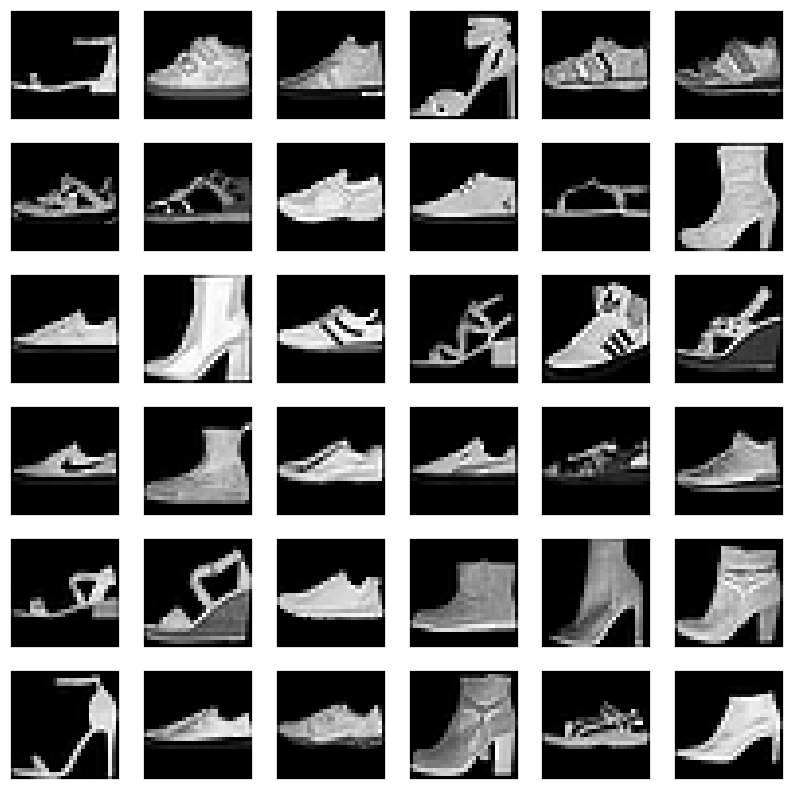

In [27]:
is_footwear = np.isin(y_train.values, [5, 7, 9])
footwear_images = X_train[is_footwear]

imshow(
	footwear_images.sample(36).values.reshape((-1, 28, 28)),
	figsize=(10, 10)
)

#### Custom Slope Algorithm for Footwear Images

To test the orientation of footwear (i.e. whether it's pointed to the left or right), we can use a slope detection algorithm.

The idea for this algorithm is below: 

```
[
	[0, 0, 0, 0, 0],
	[0, 0, 0, 1, 1],
	[0, 1, 1, 1, 1],
	[1, 1, 1, 1, 0],
	[0, 0, 0, 0, 0]
]
```

Suppose the above <code>5x5</code> is an image of our shoe. For each column, we'll find the first position where there is a non-zero value.

So for the first column it would here:

```
[
	[0, 0, 0, 0, 0],
	[0, 0, 0, 1, 1],
	[0, 1, 1, 1, 1],
	[*1*, 1, 1, 1, 0],
	[0, 0, 0, 0, 0]
]
```

For second column it would here:

```
[
	[0, 0, 0, 0, 0],
	[0, 0, 0, 1, 1],
	[0, *1*, 1, 1, 1],
	[1, 1, 1, 1, 0],
	[0, 0, 0, 0, 0]
]
```

Doing this will give us something we can call a <strong>height</strong>. For the above image, our height would be:
<code>[2, 3, 3, 4, 4]</code>

From this, we can simply determine the direction in which the slant goes. If the slant goes from low to high, it is pointed to the left, otherwise, it is pointed to the right

In [28]:
def is_left_pointed(arr):
	arr = np.array(arr)
	greater = np.where(arr.T > 0) # Gives us all index positions for non zero values
	greater_df = pd.DataFrame(greater).T # A dataframe where the first column is the column position, and the second column is the row index for non-zero values

	# We will then group by the first column (column), finding the max height for each column
	Y = len(arr) - greater_df.groupby(0).agg('min').values.flatten()
	X = np.arange(0, len(Y))
	slope = np.polyfit(X,Y,1)[0]
	return slope > 0

if not DEBUG:
	mylist = footwear_images.values.reshape((-1, 28, 28)).tolist()
	result = np.array(list(map(is_left_pointed, mylist)))

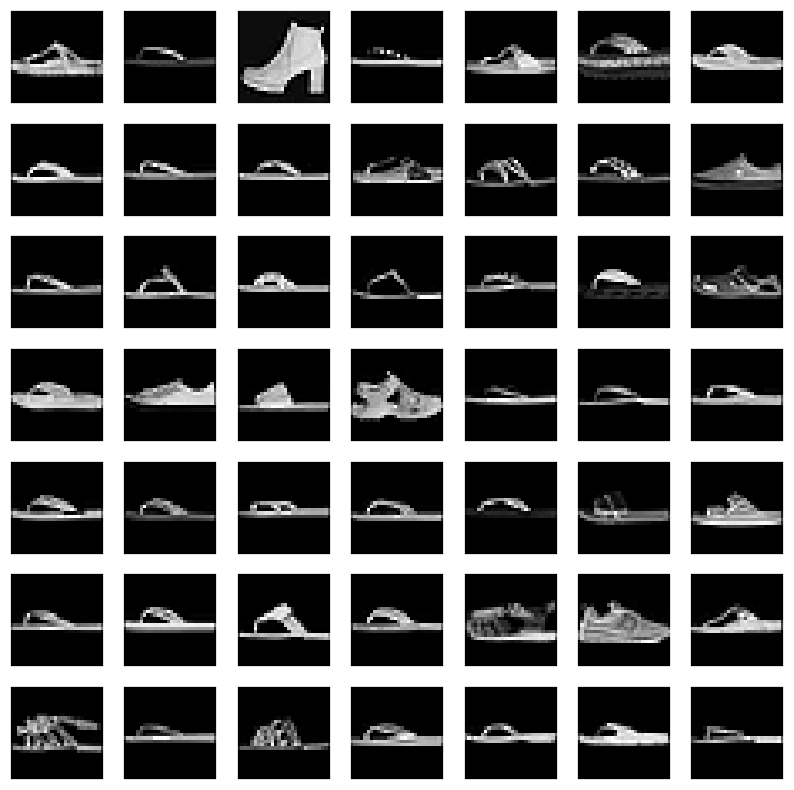

In [29]:
if not DEBUG:
	imshow(footwear_images.values.reshape((-1, 28, 28))[result == False][0:49], figsize=(10, 10))

We observe:
<ul>
	<li><strong>Most of these footwear appear to be slippers</strong>. This makes sense as our algorithm looks for the slope, which the slipper is different from something like a shoe.</li>
	<li>
		<strong>We also see images of footwear pointing to the right.</strong>
	</li>
</ul>

Thus we conclude that when performing data augmentation, we should remember to horizontally flip as well.

## Feature Engineering

We have performed feature engineering during the <strong>preprocessing step</strong>, where we divided all the values of the pixels by 255

## Data Augmentation

Data augmentation is a technique used to increase the amount of data by adding slightly modified copies of existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model (Shorten and Khoshgoftaar, 2019).

As such, performing data augmentation is likely to have a positive impact on our model performance, if our model overfits.

### Basic
For our basic augmentation, I decided to perform the following transformations:
<ul>
	<li>
		<strong>RandomHorizontalFlip</strong> - this is due to the different directions the image would 'point' as seen from our EDA
	</li>
	<li>
		<strong>RandomRotation</strong> - The goal here is not to rotate by 90 degrees, but to make slight adjustments of angles such that the model becomes more robust.
	</li>
	<li>
		<strong>RandomAffine</strong> - We'll be using affine to <strong>shear</strong> the images in the y-direction. 
	</li>
</ul>

I realised there was no need to perform cropping augmentation, as working with the dataset has shown me that the images show the item fully.

In [41]:
t_flip = transforms.RandomHorizontalFlip(p=1)
t_rotate = transforms.RandomRotation((-5, 5))


t_basic = transforms.Compose([
	transforms.RandomOrder([
		t_flip, t_rotate
	])
])

Below we see how each transformation contributes to the final image.

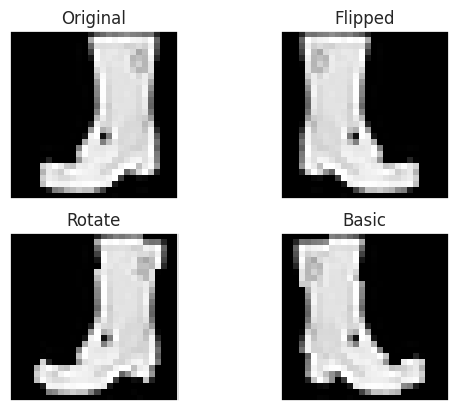

In [42]:
sample_img = copy.deepcopy(df_to_tensor(X_train.iloc[2]))
imshow([
	sample_img[0],
	t_flip(copy.deepcopy(sample_img))[0],
	t_rotate(copy.deepcopy(sample_img))[0],
	# t_shear(copy.deepcopy(sample_img))[0],
	t_basic(copy.deepcopy(sample_img))[0],
], ['Original', 'Flipped', 'Rotate', 'Basic'])

### RandomErasing
An additionally method of augmentation we can try is <strong>RandomErasing</strong>. RandomErasing is a data augmentation technique which randomly selects a rectangular region of the image and erases those pixels with random values. (Zhong et al., 2017)

Let's take a look:

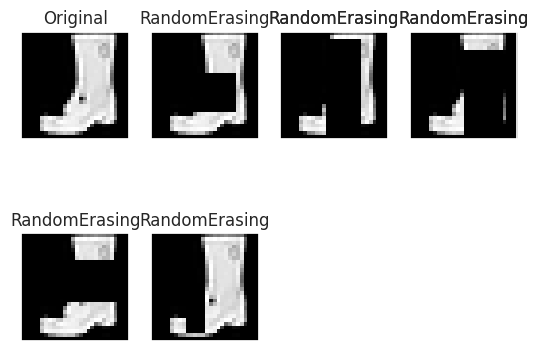

In [43]:
t_erase = transforms.RandomErasing(p = 1)

imshow([
	sample_img[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
], ['Original', 'RandomErasing', 'RandomErasing', 'RandomErasing', 'RandomErasing', 'RandomErasing', 'RandomErasing'])

As random erasing is used on top of basic augmentation, we'll make a compose transformer of the two.

In [44]:
t_erase = transforms.Compose([
	t_basic,
	transforms.RandomErasing(p = 1)
])

## Modelling

### Metric
We'll be using two metrics: <strong>Accuracy</strong> and <strong>Categorical Crossentropy</strong>

$$accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

$$\text{categorical crossentropy} = -\sum_{i=1}^{n}y_i \log{(p_i)} $$

We use accuracy to choose the model, as the benchmarks for the Fashion MNIST dataset are in terms of accuracy. Additionally, the dataset does not have an imbalanced class issue, thus using accuracy is not unsuitable.

We use categorical crossentropy as our criterion to train the model, because it heavily penalizes models that are confident and wrong in their prediction. This is due to the logarithmic function in the cross entropy formula. 

### Set up training environment
Let's set up the necessary details for our training to begin. Firstly, <strong>we define our datasets below</strong>.

In [45]:
def perform_augmentation(torch_dataset: TorchDataset, transform):
	data_copy = copy.deepcopy(torch_dataset)
	X = copy.deepcopy(data_copy.x)
	transformed = transform(X)
	data_copy.x = torch.cat((X, transformed), dim = 0)
	data_copy.y = torch.cat([data_copy.y, data_copy.y])
	return data_copy

train_data = TorchDataset(X_train, y_train)
val_data = TorchDataset(X_val, y_val)
train_augmented_erase = perform_augmentation(TorchDataset(X_train, y_train), t_erase)

#### Custom Early Stopping
Additionally, instead of <strong>arbitrarily choosing the number of epochs</strong> or fine tuning it (which computationally will take long), I decided to use <strong>Early Stopping</strong> as a mechanism.

Overfitting is something that occurs when a model begins to extract some of the residual variation such as noise under the assumption that it is learning the patterns (Burnham and Anderson, 2010). Essentially, it starts to <strong>memorize instead of generalize</strong>. Traditional Early Stopping attempts to combat overfitting by stopping training if the performance/loss of the model on a validation set does not improve over $n$ epochs, where $n$ is the patience parameter. However, it requires <strong>clever tuning</strong> to prevent underfitting (Adam, 2018). As such to address this problem, I use a custom implemented early stopping class inspired by this <a href="https://alexadam.ca/2018/08/03/early-stopping/">article</a>.

The idea of this custom early stopping is that we <strong>only stop training</strong> if there are no improvements in <strong>both loss and accuracy</strong>. If there is an improve in any of the single quantities, the patience counter is reset. This tackles the issue of the underlying assumption that <strong>"loss is correlated with accuracy</strong>", and becomes a more lenient form of early stopping, ideally decreasing underfitting.

In [46]:
class CustomEarlyStopping():
	def __init__(self, patience, min_loss_delta = 0, min_acc_delta = 0):
		self.patience = patience
		self.best_loss = 1e9
		self.best_acc = 0
		self.patience_count = 0
		self.count = 0
		self.stop = False

		self.min_loss_delta = min_loss_delta
		self.min_acc_delta = min_acc_delta

	def __call__(self, loss, accuracy):
		self.save_state = False

		if self.best_loss - loss > self.min_loss_delta or accuracy - self.best_acc > self.min_acc_delta:
			if self.best_loss - loss > self.min_loss_delta:
				self.best_loss = loss
			if accuracy - self.best_acc > self.min_acc_delta:
				self.best_acc = accuracy

			self.count = 0
		else:
			self.count += 1
		
		if self.count >= self.patience:
			self.stop = True

#### Trainer
To help us with training and determining the best models, we set up a trainer that will <strong>keep track of our models</strong> and <strong>ease the modelling process</strong>.

In [79]:
def accurate_count(pred, true):
	return ((pred.argmax(dim=1) == true.argmax(dim=1)).sum()).item()

	
class Trainer():
	def __init__(self, criterion):
		self.saves = {}
		self.loss_tracker = {}
		self.history = pd.DataFrame()

	def show_history(self):
		pass

	def train_model(self, name, model_pass, optimizer_pass, optimizer_args,
					train_data: TorchDataset, scheduler_pass = None,
					scheduler_args = None, batch_size = GPU_COUNT * 128,
					early_stopping = None, epochs = 200, verbose = False,
					val_data = val_data, save_model = False, augment = None,
					return_model = False):

		model = model_pass()
		model = model.to(device)
		model = nn.DataParallel(model)

		optimizer = optimizer_pass(model.parameters(), **optimizer_args)
		criterion = nn.CrossEntropyLoss()
		train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
		val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)

		if scheduler_pass != None:
			scheduler = scheduler_pass(optimizer, **scheduler_args)

		done = 0
		n_epochs = epochs

		track_loss = np.full((epochs, 4), 0.0, dtype=np.float32) # train acc, train loss, val acc, val loss

		best_performance_df = pd.DataFrame({'Train Loss': 1000, 'Val Loss': 1000, 'Train Acc': 0, 'Val Acc': 0}, index = [name])
		best_val_loss = 1e9
		best_val_acc = 0

		self.end_training = 0
		self.extra_trained = 0

		for epoch in range(1, n_epochs+1):
			# monitor training loss
			train_loss = 0.0
			train_acc_count = 0
			total_sample = 0
			
			###################
			# train the model #
			###################
			for data in train_loader:
				# _ stands in for labels, here
				# no need to flatten images
				inputs, labels = data

				perform_aug = np.random.random() < 0.4
				if augment != None and perform_aug:
					batch, perm, lmbd = augment['fn'](inputs.detach().cpu(), *augment['args'], **augment['kwargs'])
					optimizer.zero_grad()

					inputs = batch.cuda()

					outputs = model(inputs)
					loss = criterion(outputs, labels) * lmbd + criterion(outputs, labels[perm]) * (1 - lmbd)
					loss.backward()
				else:
					inputs = inputs.cuda()
					labels = labels.cuda()
					# clear the gradients of all optimized variables
					optimizer.zero_grad()
					# forward pass: compute predicted outputs by passing inputs to the model
					outputs = model(inputs)
					# calculate the loss
					loss = criterion(outputs, labels)
					# backward pass: compute gradient of the loss with respect to model parameters
					loss.backward()

				# perform a single optimization step (parameter update)
				optimizer.step()
				# update running training loss
				train_loss += loss.item()

				if augment != None and perform_aug:
					new_labels = labels * lmbd + labels[perm] * (1 - lmbd)
					train_acc_count += accurate_count(outputs, new_labels)
				else:
					train_acc_count += accurate_count(outputs, labels)
				total_sample += len(labels)

			if scheduler_pass != None:
				scheduler.step()
					
			# print avg training statistics 
			train_loss = train_loss/len(train_loader)
			train_acc = train_acc_count / total_sample

			val_loss = 0.0
			val_acc_count = 0
			total_sample = 0
			for i, data in enumerate(val_loader):
				inputs, labels = data                             
				inputs = inputs.to(device)
				labels = labels.to(device)
																
				outputs = model(inputs)
				loss = criterion(outputs, labels)

				val_loss += loss.item()
				val_acc_count += accurate_count(outputs, labels)
				total_sample += len(labels)

			val_loss = val_loss / len(val_loader)
			val_acc = val_acc_count / total_sample

			if verbose:
				print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} \tVal Loss: {val_loss:.5f} \tTrain Acc: {train_acc:.3f} \tVal Acc: {val_acc:.3f}")

			track_loss[epoch - 1][0] = train_acc
			track_loss[epoch - 1][1] = train_loss
			track_loss[epoch - 1][2] = val_acc
			track_loss[epoch - 1][3] = val_loss
			done = epoch

			if val_loss < best_val_loss:
				best_performance_df = pd.DataFrame({'Train Loss': train_loss, 'Val Loss': val_loss, 'Train Acc': train_acc, 'Val Acc': val_acc}, index = [name])
				self.end_training = epoch
				best_val_loss = val_loss
				if save_model:
					self.save_model(name, model)
			elif val_acc > best_val_acc:
				best_performance_df = pd.DataFrame({'Train Loss': train_loss, 'Val Loss': val_loss, 'Train Acc': train_acc, 'Val Acc': val_acc}, index = [name])
				self.end_training = epoch
				best_val_acc = val_acc
				if save_model:
					self.save_model(name, model)

			early_stopping(val_loss, val_acc)

			if early_stopping != None and early_stopping.stop:
				if (verbose):
					print(f"Stopping due to early stopping | patience = {early_stopping.patience}")
				break


		track_loss.resize((done, 4))
		self.record(name, track_loss, best_performance_df)

		if return_model:
			del train_loader, val_loader, inputs, labels
			torch.cuda.empty_cache()
			return model
		else:
			del model, optimizer, train_loader, val_loader, inputs, labels
			torch.cuda.empty_cache()

	def record(self, name, track_loss, best_performance_df):
		track_loss_df = pd.DataFrame(track_loss, columns=['Train Acc', 'Train Loss', 'Val Acc', 'Val Loss'])
		track_loss_df.index += 1
		track_loss_df.index.name = 'Epoch'

		self.history = pd.concat([self.history, best_performance_df], axis=0)
		self.loss_tracker[name] = track_loss_df

	def save_model(self, name, model):
		self.saves[name] = copy.deepcopy(model)

	def get_model(self, name):
		return copy.deepcopy(self.saves[name])

	def archive(self, name):
		fig = plt.figure(figsize=(14, 5))
		train, val = sns.color_palette('Set2')[0:2]
		loss, acc = fig.subplots(1, 2)

		loss.axvspan(1, self.end_training, color=sns.color_palette('Paired')[0], alpha=0.4, lw=0, label='Training') 

		loss.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Train Loss'], label='Train', color=train)
		loss.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Val Loss'], label='Val', color=val)
		loss.set_xlabel('Epoch')
		loss.set_ylabel('Loss')

		acc.axvspan(1, self.end_training, color=sns.color_palette('Paired')[0], alpha=0.4, lw=0, label='Training') 
		acc.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Train Acc'], label='Train', color=train)
		acc.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Val Acc'], label='Val', color=val)

		acc.set_xlabel('Epoch')
		acc.set_ylabel('Accuracy')
		acc.set_ylim(0.60, 1)


		acc.legend()
		loss.legend()
		
		fig.savefig(f'plots/{name}.png')
		plt.close()
		del self.loss_tracker[name]

We instantiate our trainer with our validation data, along with our loss function: <strong>categorical crossentropy</strong>

In [48]:
trainer = Trainer(nn.CrossEntropyLoss)

### Model Architectures
We can now get started with determining the best non-fine-tuned model to proceed with.

#### Baseline - NN
As our baseline, we'll use a simple neural network consisting of:
<ol>
<li>Linear layer</li>
<li>Batch Normalization</li>
<li>ReLU</li>
</ol>

In [49]:
if not MODEL_DEBUG:
    class BaseNN(nn.Module):
        def __init__(self):
            super(BaseNN, self).__init__()

            self.flat = nn.Flatten(1)

            self.fc1 = nn.Linear(784, 256)
            self.fc1_bn = nn.BatchNorm1d(256)
            self.fc1_act = nn.ReLU()

            self.fc2 = nn.Linear(256, 64)
            self.fc2_bn = nn.BatchNorm1d(64)
            self.fc2_act = nn.ReLU()

            self.fc3 = nn.Linear(64, 16)
            self.fc3_bn = nn.BatchNorm1d(16)
            self.fc3_act = nn.ReLU()

            self.fc4 = nn.Linear(16, 10)
            self.fc4_bn = nn.BatchNorm1d(10)
            self.fc4_act = nn.ReLU()

        def get_logits(self, x):
            x = self.flat(x)
            x = self.fc1_act(self.fc1_bn(self.fc1(x)))
            x = self.fc2_act(self.fc2_bn(self.fc2(x)))
            x = self.fc3_act(self.fc3_bn(self.fc3(x)))
            x = self.fc4_act(self.fc4_bn(self.fc4(x)))
            logits = x
            return logits

        def forward(self, x):
            return self.get_logits(x)

In [50]:
if not MODEL_DEBUG:
	trainer.train_model(
		'Baseline NN', BaseNN, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('Baseline NN')
	display(trainer.history)

Epoch: 1 | Train Loss: 2.23655 	Val Loss: 2.22060 	Train Acc: 0.808 	Val Acc: 0.853
Epoch: 2 | Train Loss: 2.21273 	Val Loss: 2.20876 	Train Acc: 0.860 	Val Acc: 0.864
Epoch: 3 | Train Loss: 2.20336 	Val Loss: 2.20208 	Train Acc: 0.873 	Val Acc: 0.873
Epoch: 4 | Train Loss: 2.19837 	Val Loss: 2.19861 	Train Acc: 0.881 	Val Acc: 0.873
Epoch: 5 | Train Loss: 2.19545 	Val Loss: 2.19660 	Train Acc: 0.884 	Val Acc: 0.875
Epoch: 6 | Train Loss: 2.19337 	Val Loss: 2.19536 	Train Acc: 0.889 	Val Acc: 0.874
Epoch: 7 | Train Loss: 2.19162 	Val Loss: 2.19486 	Train Acc: 0.894 	Val Acc: 0.875
Epoch: 8 | Train Loss: 2.19062 	Val Loss: 2.19402 	Train Acc: 0.895 	Val Acc: 0.879
Epoch: 9 | Train Loss: 2.18991 	Val Loss: 2.19299 	Train Acc: 0.898 	Val Acc: 0.878
Epoch: 10 | Train Loss: 2.18939 	Val Loss: 2.19238 	Train Acc: 0.897 	Val Acc: 0.880
Epoch: 11 | Train Loss: 2.18812 	Val Loss: 2.19174 	Train Acc: 0.904 	Val Acc: 0.882
Epoch: 12 | Train Loss: 2.18770 	Val Loss: 2.19193 	Train Acc: 0.905 	Val 

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,2.180259,2.187941,0.94288,0.8955


<img src="plots/Baseline NN.png">

We observe:
<ul>
	<li>Despite using early stopping, we can identify <strong>large amounts of overfitting</strong></li>
	<li>This suggests not that early stopping is bad, but using this model means we allow the model to overfit, <strong>as long as the validation is improving.</strong></li>
	<li>This means that training is perhaps inefficient but not terrible, as for each epoch, <strong>we learn more noise than pattern</strong></li>
	<li>With a patience parameter of <code>10</code>, Early Stopping has stopped our training at <strong>Epoch = 20</strong></li>
	<li>Surprisingly, the baseline performance is impressive for a basic model at 0.89 accuracy</strong>
</ul>

#### Augmentation + Baseline NN

In [51]:
if not MODEL_DEBUG:
	trainer.train_model(
		'Baseline NN + Aug_Erase', BaseNN, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('Baseline NN + Aug_Erase')
	display(trainer.history)

Epoch: 1 | Train Loss: 2.22838 	Val Loss: 2.21160 	Train Acc: 0.811 	Val Acc: 0.850
Epoch: 2 | Train Loss: 2.20361 	Val Loss: 2.20105 	Train Acc: 0.861 	Val Acc: 0.861
Epoch: 3 | Train Loss: 2.19696 	Val Loss: 2.19788 	Train Acc: 0.872 	Val Acc: 0.864
Epoch: 4 | Train Loss: 2.19370 	Val Loss: 2.19521 	Train Acc: 0.879 	Val Acc: 0.875
Epoch: 5 | Train Loss: 2.19187 	Val Loss: 2.19386 	Train Acc: 0.883 	Val Acc: 0.874
Epoch: 6 | Train Loss: 2.19059 	Val Loss: 2.19316 	Train Acc: 0.887 	Val Acc: 0.876
Epoch: 7 | Train Loss: 2.18973 	Val Loss: 2.19258 	Train Acc: 0.890 	Val Acc: 0.876
Epoch: 8 | Train Loss: 2.18891 	Val Loss: 2.19157 	Train Acc: 0.893 	Val Acc: 0.879
Epoch: 9 | Train Loss: 2.18847 	Val Loss: 2.19315 	Train Acc: 0.895 	Val Acc: 0.871
Epoch: 10 | Train Loss: 2.18782 	Val Loss: 2.19208 	Train Acc: 0.898 	Val Acc: 0.876
Epoch: 11 | Train Loss: 2.18740 	Val Loss: 2.19332 	Train Acc: 0.900 	Val Acc: 0.871
Epoch: 12 | Train Loss: 2.18718 	Val Loss: 2.19117 	Train Acc: 0.900 	Val 

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,2.180259,2.187941,0.94288,0.8955
Baseline NN + Aug_Erase,2.179294,2.187869,0.94913,0.8946


We observe:

#### Convolutional Neural Networks (LeNet)

Convolutional Neural Networks (also known as ConvNets or CNNs) is a class of neural networks, with its most popular use case being in analyzing visual imagery (Valueva et al., 2020).

We'll use the LNet architecture.

In [52]:
if not MODEL_DEBUG:
	class LeNet(nn.Module):
		def __init__(self):
			super(LeNet, self).__init__()

			self.conv1 = nn.Conv2d(1, 6, 5, padding = 2)
			self.sig1 = nn.Sigmoid()
			self.pool1 = nn.AvgPool2d(2, stride=2)

			self.conv2 = nn.Conv2d(6, 16, 5, padding = 0)
			self.sig2 = nn.Sigmoid()
			self.pool2 = nn.AvgPool2d(2, stride=2)

			self.flat = nn.Flatten(start_dim=1)

			self.fc1 = nn.Linear(16 * 5 * 5, 120)
			self.sig_fc1 = nn.Sigmoid()

			self.fc2 = nn.Linear(120, 84)
			self.sig_fc2 = nn.Sigmoid()

			self.fc3 = nn.Linear(84, 10)

		def forward(self, x):
			x = self.pool1(self.sig1(self.conv1(x)))
			x = self.pool2(self.sig2(self.conv2(x)))
			x = self.flat(x)
			x = self.sig_fc1(self.fc1(x))
			x = self.sig_fc2(self.fc2(x))
			x = self.fc3(x)
			return x

In [53]:
if not MODEL_DEBUG:
	trainer.train_model(
		'LeNet', LeNet, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('LeNet')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,2.180259,2.187941,0.94288,0.8955
Baseline NN + Aug_Erase,2.179294,2.187869,0.94913,0.8946
LeNet,1.532261,1.557959,0.93236,0.9012


#### Augmentation + CNN (LeNet)

In [54]:
if not MODEL_DEBUG:
	trainer.train_model(
		'LeNet + Aug_Erase', LeNet, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('LeNet + Aug_Erase')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,2.180259,2.187941,0.94288,0.8955
Baseline NN + Aug_Erase,2.179294,2.187869,0.94913,0.8946
LeNet,1.532261,1.557959,0.93236,0.9012
LeNet + Aug_Erase,1.539837,1.559159,0.92447,0.9054


We observe:

#### ResNet-S

In [55]:
if not MODEL_DEBUG:
	def relu_bn_conv(in_channels, out_channels, **kwargs):
		return nn.Sequential(
			nn.Conv2d(in_channels, out_channels, **kwargs),
			nn.BatchNorm2d(out_channels),
			nn.ReLU()
		)

	class ResBlock(nn.Module):
		def __init__(self, in_channels, out_channels, skip = False):
			super().__init__()
			self.skip = nn.Sequential()
			self.conv1 = relu_bn_conv(in_channels, out_channels, kernel_size = 3, padding = 1)

			if skip:
				self.conv1 = relu_bn_conv(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)
				self.skip = nn.Conv2d(in_channels, out_channels, kernel_size= 1, stride = 2)

			self.conv2 = relu_bn_conv(out_channels, out_channels, kernel_size = 3, padding = 1)

		def forward(self, x):
			skip = self.skip(x)
			x = self.conv1(x)
			x = self.conv2(x)
			x = x + skip
			return nn.ReLU()(x)

In [56]:
if not MODEL_DEBUG:
	class ResNetS(nn.Module):
		def __init__(self, base_filter = 16):
			super().__init__()

			in_channels = 1
			
			self.l0 = nn.Sequential(
				nn.Conv2d(in_channels, base_filter, kernel_size = 7, stride = 2, padding = 3),
				nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
				nn.BatchNorm2d(base_filter),
				nn.ReLU()
			)
			self.l1 = nn.Sequential(
				ResBlock(base_filter, base_filter, skip = False),
				ResBlock(base_filter, base_filter, skip = False),
			)
			self.l2 = nn.Sequential(
				ResBlock(base_filter, base_filter * 2, skip = True),
				ResBlock(base_filter * 2, base_filter * 2, skip = False),
			)
			self.l3 = nn.Sequential(
				ResBlock(base_filter * 2, base_filter * 3, skip = True),
				ResBlock(base_filter * 3, base_filter * 3, skip = False),
			)
			self.gap = torch.nn.AdaptiveAvgPool2d(1)
			self.fc = nn.Sequential(
				nn.Flatten(start_dim=1),
				torch.nn.Linear(base_filter * 3, 10)
			)

		def forward(self, x):
			x = self.l0(x)
			x = self.l1(x)
			x = self.l2(x)
			x = self.l3(x)
			x = self.gap(x)
			x = self.fc(x)

			return x

In [57]:
if not MODEL_DEBUG:
	trainer.train_model(
		'ResNet-S', ResNetS, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('ResNet-S')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,2.180259,2.187941,0.94288,0.8955
Baseline NN + Aug_Erase,2.179294,2.187869,0.94913,0.8946
LeNet,1.532261,1.557959,0.93236,0.9012
LeNet + Aug_Erase,1.539837,1.559159,0.92447,0.9054
ResNet-S,1.509708,1.556440,0.95168,0.9041


#### Augmentation + ResNet-S

In [58]:
if not MODEL_DEBUG:
	trainer.train_model(
		'ResNet-S + Aug_Erase', ResNetS, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('ResNet-S + Aug_Erase')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,2.180259,2.187941,0.94288,0.8955
Baseline NN + Aug_Erase,2.179294,2.187869,0.94913,0.8946
LeNet,1.532261,1.557959,0.93236,0.9012
LeNet + Aug_Erase,1.539837,1.559159,0.92447,0.9054
ResNet-S,1.509708,1.556440,0.95168,0.9041
ResNet-S + Aug_Erase,1.516521,1.551573,0.94485,0.9070


#### ResNet18

In [59]:
if not MODEL_DEBUG:
	class ResNet18(nn.Module):
		def __init__(self, base_filter = 64):
			super().__init__()

			in_channels = 1
			
			self.l0 = nn.Sequential(
				nn.Conv2d(in_channels, base_filter, kernel_size = 7, stride = 2, padding = 3),
				nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
				nn.BatchNorm2d(base_filter),
				nn.ReLU()
			)
			self.l1 = nn.Sequential(
				ResBlock(base_filter, base_filter, skip = False),
				ResBlock(base_filter, base_filter, skip = False),
			)
			self.l2 = nn.Sequential(
				ResBlock(base_filter, base_filter * 2, skip = True),
				ResBlock(base_filter * 2, base_filter * 2, skip = False),
			)
			self.l3 = nn.Sequential(
				ResBlock(base_filter * 2, base_filter * 3, skip = True),
				ResBlock(base_filter * 3, base_filter * 3, skip = False),
			)
			self.l4 = nn.Sequential(
				ResBlock(base_filter * 3, base_filter * 4, skip = True),
				ResBlock(base_filter * 4, base_filter * 4, skip = False),
			)
			self.gap = torch.nn.AdaptiveAvgPool2d(1)
			self.fc = nn.Sequential(
				nn.Flatten(start_dim=1),
				torch.nn.Linear(base_filter * 4, 10)
			)

		def forward(self, x):
			x = self.l0(x)
			x = self.l1(x)
			x = self.l2(x)
			x = self.l3(x)
			x = self.l4(x)
			x = self.gap(x)
			x = self.fc(x)

			return x


In [60]:
if not MODEL_DEBUG:
	trainer.train_model(
		'ResNet18', ResNet18, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('ResNet18')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,2.180259,2.187941,0.94288,0.8955
Baseline NN + Aug_Erase,2.179294,2.187869,0.94913,0.8946
LeNet,1.532261,1.557959,0.93236,0.9012
LeNet + Aug_Erase,1.539837,1.559159,0.92447,0.9054
ResNet-S,1.509708,1.556440,0.95168,0.9041
ResNet-S + Aug_Erase,1.516521,1.551573,0.94485,0.9070
ResNet18,1.510253,1.547438,0.95096,0.9154


#### Augmentation + ResNet18

In [61]:
if not MODEL_DEBUG:
	trainer.train_model(
		'ResNet18 + Aug_Erase', ResNet18, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False,
	)
	trainer.archive('ResNet18 + Aug_Erase')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,2.180259,2.187941,0.94288,0.8955
Baseline NN + Aug_Erase,2.179294,2.187869,0.94913,0.8946
LeNet,1.532261,1.557959,0.93236,0.9012
LeNet + Aug_Erase,1.539837,1.559159,0.92447,0.9054
ResNet-S,1.509708,1.556440,0.95168,0.9041
ResNet-S + Aug_Erase,1.516521,1.551573,0.94485,0.9070
ResNet18,1.510253,1.547438,0.95096,0.9154
ResNet18 + Aug_Erase,1.507795,1.545343,0.95326,0.9182


#### VGG13

In [80]:
def VGGBlock(in_channels, out_channels, pool = False, activation = nn.ReLU):
	if pool:
		return nn.Sequential(
			nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
			nn.BatchNorm2d(out_channels),
			activation(),
			nn.MaxPool2d(kernel_size = 2, stride = 2)
		)
	return nn.Sequential(
		nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
		nn.BatchNorm2d(out_channels),
		activation()
	)

class VGG13(nn.Module):
	def __init__(self):
		super().__init__()
		self.l0 = VGGBlock(1, 64)
		self.l1 = VGGBlock(64, 64, pool = True)
		self.l2 = VGGBlock(64, 128)
		self.l3 = VGGBlock(128, 128, pool = True)
		self.l4 = VGGBlock(128, 256)
		self.l5 = VGGBlock(256, 256)
		self.l6 = VGGBlock(256, 256, pool = True)
		self.l7 = VGGBlock(256, 512)
		self.l8 = VGGBlock(512, 512)
		self.l9 = VGGBlock(512, 512, pool = True)
		self.fc0 = nn.Sequential(
			nn.Flatten(start_dim = 1),
			nn.Dropout(0.5),
			nn.Linear(512, 4096),
			nn.ReLU()
		)
		self.fc1 = nn.Sequential(
			nn.Dropout(0.5),
			nn.Linear(4096, 4096),
			nn.ReLU()
		)
		self.fc2 = nn.Sequential(
			nn.Linear(4096, 10)
		)


	def forward(self, x):
		x = self.l0(x)
		x = self.l1(x)
		x = self.l2(x)
		x = self.l3(x)
		x = self.l4(x)
		x = self.l5(x)
		x = self.l6(x)
		x = self.l7(x)
		x = self.l8(x)
		x = self.l9(x)
		x = self.fc0(x)
		x = self.fc1(x)
		x = self.fc2(x)
		return x
    
	def __repr__(self):
		return "VGG13"

In [81]:
trainer = Trainer(nn.CrossEntropyLoss)

if not MODEL_DEBUG:
	trainer.train_model(
		'VGG13', VGG13, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT ** 0.5), 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True,
	)
	trainer.archive('VGG13')
	display(trainer.history)

Epoch: 1 | Train Loss: 1.25821 	Val Loss: 0.61051 	Train Acc: 0.514 	Val Acc: 0.771
Epoch: 2 | Train Loss: 0.49374 	Val Loss: 0.37690 	Train Acc: 0.819 	Val Acc: 0.868
Epoch: 3 | Train Loss: 0.35693 	Val Loss: 0.32746 	Train Acc: 0.876 	Val Acc: 0.887
Epoch: 4 | Train Loss: 0.29367 	Val Loss: 0.30577 	Train Acc: 0.899 	Val Acc: 0.900
Epoch: 5 | Train Loss: 0.26540 	Val Loss: 0.30383 	Train Acc: 0.909 	Val Acc: 0.901
Epoch: 6 | Train Loss: 0.23943 	Val Loss: 0.24201 	Train Acc: 0.919 	Val Acc: 0.918
Epoch: 7 | Train Loss: 0.22694 	Val Loss: 0.26699 	Train Acc: 0.922 	Val Acc: 0.913
Epoch: 8 | Train Loss: 0.19994 	Val Loss: 0.24938 	Train Acc: 0.933 	Val Acc: 0.917
Epoch: 9 | Train Loss: 0.18271 	Val Loss: 0.24956 	Train Acc: 0.936 	Val Acc: 0.920
Epoch: 10 | Train Loss: 0.17000 	Val Loss: 0.23054 	Train Acc: 0.941 	Val Acc: 0.926
Epoch: 11 | Train Loss: 0.16156 	Val Loss: 0.25069 	Train Acc: 0.943 	Val Acc: 0.922
Epoch: 12 | Train Loss: 0.15742 	Val Loss: 0.25213 	Train Acc: 0.947 	Val 

,Train Loss,Val Loss,Train Acc,Val Acc
VGG13,0.03607,0.435779,0.99022,0.9321



#### Augmentation + VGG


In [82]:
if not MODEL_DEBUG:
	trainer.train_model(
		'VGG13 + Aug_Erase', VGG13, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('VGG13 + Aug_Erase')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
VGG13,0.036070,0.435779,0.99022,0.9321
VGG13 + Aug_Erase,0.049573,0.342483,0.98359,0.9384


We observe:
	Deep convolution structure performs better than residual networks.

#### Modified CoAtNet-0
With the rise in transformers, there has been a growing interest in the <strong>Attention mechanism</strong> and its uses in computer vision.

The problem is inductive bias of vision transformers, without being pretrained on a dataset, the performance is found to be worse than state of the art convnet. (https://analyticsindiamag.com/a-guide-to-coatnet-the-combination-of-convolution-and-attention-networks/). 

Below, we use CoAtNet-0, which is an architecture that <strong>marries</strong> Convolution blocks (specifically MBConvs from MobileNet) and Transformer Blocks"

However, the smallest model CoAtNet-0 is quite an overkill for this dataset due to it's large number of parameters, despite being the smallest version. As such, we the following adjustments to make the model smaller.

<ul>
	<li>Change from the architecture of
	<code>Conv + Conv + Trans + Trans -> Conv + Conv + Conv + Trans </code>
	</li>
	<li>
	<strong>Reduced</strong> downsampling frequency to downsample only at layer 3 and 5. This is such due <strong>to the smaller image size</strong> of our data being <code>28x28</code>.
	</li>
	<li>
		<strong>Downsampling frequency skewed to the right</strong>. This means we move the downsampling layers towards the later, such that we can <strong>increase the amount of information that the earlier layers can capture.</strong>
	</li>
	<li>
		The <strong>number of blocks and channels were also reduced</strong>. This is done as the dataset is quite small and does not need an incredibly deep network (CoAtNet-0 was originally meant for <code>224x224x3</code> images)
	</li>
</ul>

In [83]:
def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)


        self.pool = nn.MaxPool2d(3, 2, 1)
        self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # down-sample in the first conv
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample:
            return self.proj(self.pool(x)) + self.conv(x)
        else:
            return self.proj(x) + self.conv(x)

# torch.nn.MultiheadAttention()
# self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)

class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)

        self.ih, self.iw = image_size
        self.downsample = downsample

        self.pool1 = nn.MaxPool2d(3, 2, 1)
        self.pool2 = nn.MaxPool2d(3, 2, 1)
        self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.downsample:
            x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else:
            x = self.proj(x) + self.attn(x)
        x = x + self.ff(x)
        return x

class CoAtNet(nn.Module):
    def __init__(self):
        super().__init__()
        image_size = (28, 28)
        in_channels = 1
        num_blocks = [2, 2, 3, 3, 2]            # L
        channels = [64, 64, 128, 128, 256]
        num_classes = 10
        block_types = ['C', 'C', 'C', 'T']
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s0 = self._make_layer(
            conv_3x3_bn, in_channels, channels[0], num_blocks[0], (ih // 1, iw // 1), downsample = False)
        self.s1 = self._make_layer(
            block[block_types[0]], channels[0], channels[1], num_blocks[1], (ih // 1, iw // 1), downsample = False)
        self.s2 = self._make_layer(
            block[block_types[1]], channels[1], channels[2], num_blocks[2], (ih // 2, iw // 2), downsample = True)
        self.s3 = self._make_layer(
            block[block_types[2]], channels[2], channels[3], num_blocks[3], (ih // 2, iw // 2), downsample = False)
        self.s4 = self._make_layer(
            block[block_types[3]], channels[3], channels[4], num_blocks[4], (ih // 4, iw // 4), downsample = True)
        self.pool = nn.AvgPool2d(ih // 4, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        global error_maker
        # if x.shape[1] == 1 and x.shape[2] == 28:
        #     error_maker = copy.deepcopy(x)
        x = self.s0(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

    def _make_layer(self, block, inp, oup, depth, image_size, downsample = False):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=downsample))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)

    def __repr__(self):
        return "Modified CoAtNet0"

In [84]:
if not MODEL_DEBUG:
	trainer.train_model(
		'Modified CoAtNet0', CoAtNet, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('Modified CoAtNet0')
	display(trainer.history)

/opt/conda/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


,Train Loss,Val Loss,Train Acc,Val Acc
VGG13,0.036070,0.435779,0.99022,0.9321
VGG13 + Aug_Erase,0.049573,0.342483,0.98359,0.9384
Modified CoAtNet0,0.045005,0.304588,0.98444,0.9320



#### Augmentation + CoAtNet

In [85]:
if not MODEL_DEBUG:
	trainer.train_model(
		'Modified CoAtNet0 + Aug_Erase', CoAtNet, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('Modified CoAtNet0 + Aug_Erase')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
VGG13,0.036070,0.435779,0.99022,0.9321
VGG13 + Aug_Erase,0.049573,0.342483,0.98359,0.9384
Modified CoAtNet0,0.045005,0.304588,0.98444,0.9320
Modified CoAtNet0 + Aug_Erase,0.099257,0.213295,0.96385,0.9361


We observe:

It seems that CoAtNet appears to work well. However, let's investigate whether or not this is <strong>due to the Transformer blocks, or due to the MBConv layer.</strong>

To find this out, we'll test the model architecture that first introduced the MBConv layers, MobileNet. This experiment is not expensive, as MobileNet has beeen designed for efficiency purposes.

#### Modified MobileNetV2


In [86]:
class MobileNetV2(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv0 = nn.Conv2d(1, 32, 1)
		self.mb1 = MBConv(32, 16, (28, 28), downsample = False, expansion = 1)
		self.mb2 = MBConv(16, 24, (28, 28), downsample = False, expansion = 6)
		self.mb3 = MBConv(24, 32, (14, 14), downsample = True, expansion = 6)
		self.mb4 = MBConv(32, 64, (14, 14), downsample = False, expansion = 6)
		self.mb5 = MBConv(64, 96, (7, 7), downsample = True, expansion = 6)
		self.mb6 = MBConv(96, 160, (7, 7), downsample = False, expansion = 6)
		self.mb7 = MBConv(160, 320, (3, 3), downsample = True, expansion = 6)
		self.conv1 = nn.Conv2d(320, 1280, 1)
		self.conv2 = nn.AvgPool2d(3)
		self.conv3 = nn.Conv2d(1280, 10, 1)

	def forward(self, x):
		x = self.conv0(x)
		x = self.mb1(x)
		x = self.mb2(x)
		x = self.mb3(x)
		x = self.mb4(x)
		x = self.mb5(x)
		x = self.mb6(x)
		x = self.mb7(x)
		x = self.conv1(x)
		x = self.conv2(x)
		x = self.conv3(x)
		x = x[:,:,0,0]
		return x

if not MODEL_DEBUG:
	trainer.train_model(
		'MobileNetV2', MobileNetV2, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_data, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=False
	)
	trainer.archive('MobileNetV2')
	display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
VGG13,0.036070,0.435779,0.99022,0.9321
VGG13 + Aug_Erase,0.049573,0.342483,0.98359,0.9384
Modified CoAtNet0,0.045005,0.304588,0.98444,0.9320
Modified CoAtNet0 + Aug_Erase,0.099257,0.213295,0.96385,0.9361
MobileNetV2,0.002506,0.446302,0.99926,0.9314


#### Augmentation + Modified MobileNet V2

In [87]:
if not MODEL_DEBUG:
	trainer.train_model(
		'MobileNetV2 + Aug_Erase', MobileNetV2, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		train_augmented_erase, # data
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True
	)
	trainer.archive('MobileNetV2 + Aug_Erase')
	display(trainer.history)

Epoch: 1 | Train Loss: 0.44009 	Val Loss: 0.28475 	Train Acc: 0.842 	Val Acc: 0.903
Epoch: 2 | Train Loss: 0.23664 	Val Loss: 0.25540 	Train Acc: 0.915 	Val Acc: 0.912
Epoch: 3 | Train Loss: 0.19529 	Val Loss: 0.23522 	Train Acc: 0.929 	Val Acc: 0.914
Epoch: 4 | Train Loss: 0.16240 	Val Loss: 0.24503 	Train Acc: 0.941 	Val Acc: 0.913
Epoch: 5 | Train Loss: 0.14220 	Val Loss: 0.24347 	Train Acc: 0.950 	Val Acc: 0.917
Epoch: 6 | Train Loss: 0.11735 	Val Loss: 0.23966 	Train Acc: 0.957 	Val Acc: 0.921
Epoch: 7 | Train Loss: 0.10406 	Val Loss: 0.27937 	Train Acc: 0.962 	Val Acc: 0.921
Epoch: 8 | Train Loss: 0.09710 	Val Loss: 0.28944 	Train Acc: 0.965 	Val Acc: 0.906
Epoch: 9 | Train Loss: 0.08098 	Val Loss: 0.26431 	Train Acc: 0.970 	Val Acc: 0.924
Epoch: 10 | Train Loss: 0.07366 	Val Loss: 0.30642 	Train Acc: 0.974 	Val Acc: 0.917
Epoch: 11 | Train Loss: 0.06427 	Val Loss: 0.32622 	Train Acc: 0.977 	Val Acc: 0.916
Epoch: 12 | Train Loss: 0.06533 	Val Loss: 0.33946 	Train Acc: 0.977 	Val 

,Train Loss,Val Loss,Train Acc,Val Acc
VGG13,0.036070,0.435779,0.99022,0.9321
VGG13 + Aug_Erase,0.049573,0.342483,0.98359,0.9384
Modified CoAtNet0,0.045005,0.304588,0.98444,0.9320
Modified CoAtNet0 + Aug_Erase,0.099257,0.213295,0.96385,0.9361
MobileNetV2,0.002506,0.446302,0.99926,0.9314
MobileNetV2 + Aug_Erase,0.011083,0.415800,0.99612,0.9297


We observe that both VGG13 and Modified CoAtNet-0 with <strong>no data augmentation</strong> lead to the best results.

### Model size vs Performance

In [88]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Model Improvement

#### New Augmentation Technique
We recognize that although data augmentation is supposed to improve our scores, it appears that our data augmentation does not have a positive effect. As such, we can try two different types of augmentation:
<ul>
	<li>CutMix</li>
	<li>FMix</li>
</ul>

CutMix essentially takes one rectangle patch from an image, and replaces this patch with another image.

In [89]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(inputs, beta):
    lam = np.random.beta(beta, beta)
    rand_index = torch.randperm(inputs.size()[0])
    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
    # new_labels = labels * lam + labels[rand_index] * (1 - lam)
    return inputs, rand_index, lam

In [90]:
if not MODEL_IMPROVE_DEBUG:
	trainer = Trainer(nn.CrossEntropyLoss)

	trainer.train_model(
		'VGG13 + Aug_CutMix', VGG13, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		# train_cutmix_base_data, # data
		train_data,
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True,
		augment={
			'fn': cutmix,
			'args': [1],
			'kwargs': {}
		}
	)

	trainer.archive('VGG13 + Aug_CutMix')
	display(trainer.history)

Epoch: 1 | Train Loss: 1.86005 	Val Loss: 1.05241 	Train Acc: 0.328 	Val Acc: 0.564
Epoch: 2 | Train Loss: 1.19113 	Val Loss: 0.68769 	Train Acc: 0.615 	Val Acc: 0.779
Epoch: 3 | Train Loss: 0.97034 	Val Loss: 0.48723 	Train Acc: 0.729 	Val Acc: 0.836
Epoch: 4 | Train Loss: 0.80143 	Val Loss: 0.34755 	Train Acc: 0.785 	Val Acc: 0.880
Epoch: 5 | Train Loss: 0.79203 	Val Loss: 0.36395 	Train Acc: 0.802 	Val Acc: 0.881
Epoch: 6 | Train Loss: 0.66326 	Val Loss: 0.31837 	Train Acc: 0.832 	Val Acc: 0.893
Epoch: 7 | Train Loss: 0.63848 	Val Loss: 0.28576 	Train Acc: 0.833 	Val Acc: 0.904
Epoch: 8 | Train Loss: 0.65318 	Val Loss: 0.26144 	Train Acc: 0.831 	Val Acc: 0.917
Epoch: 9 | Train Loss: 0.63841 	Val Loss: 0.24713 	Train Acc: 0.847 	Val Acc: 0.918
Epoch: 10 | Train Loss: 0.59750 	Val Loss: 0.22978 	Train Acc: 0.847 	Val Acc: 0.922
Epoch: 11 | Train Loss: 0.51502 	Val Loss: 0.23018 	Train Acc: 0.865 	Val Acc: 0.922
Epoch: 12 | Train Loss: 0.54296 	Val Loss: 0.26008 	Train Acc: 0.865 	Val 

,Train Loss,Val Loss,Train Acc,Val Acc
VGG13 + Aug_CutMix,0.40041,0.299949,0.911,0.939


In [92]:
if not MODEL_IMPROVE_DEBUG:
	trainer = Trainer(nn.CrossEntropyLoss)

	trainer.train_model(
		'Modified CoAtNet0 + Aug_CutMix', CoAtNet, # model
		optim.Adam, {'lr': 1e-3 * (GPU_COUNT) ** 0.5, 'weight_decay': 1e-5}, # optimizer
		# train_cutmix_base_data, # data
		train_augmented_erase,
		early_stopping = CustomEarlyStopping(patience = 15),
		verbose=True,
		augment={
			'fn': cutmix,
			'args': [1],
			'kwargs': {}
		}
	)

	trainer.archive('Modified CoAtNet0 + Aug_CutMix')
	display(trainer.history)

Epoch: 1 | Train Loss: 0.79965 	Val Loss: 0.34135 	Train Acc: 0.780 	Val Acc: 0.884
Epoch: 2 | Train Loss: 0.63737 	Val Loss: 0.26974 	Train Acc: 0.840 	Val Acc: 0.907
Epoch: 3 | Train Loss: 0.54660 	Val Loss: 0.25492 	Train Acc: 0.865 	Val Acc: 0.911
Epoch: 4 | Train Loss: 0.52330 	Val Loss: 0.22919 	Train Acc: 0.868 	Val Acc: 0.925
Epoch: 5 | Train Loss: 0.46451 	Val Loss: 0.21376 	Train Acc: 0.882 	Val Acc: 0.927
Epoch: 6 | Train Loss: 0.45260 	Val Loss: 0.19996 	Train Acc: 0.881 	Val Acc: 0.930
Epoch: 7 | Train Loss: 0.45102 	Val Loss: 0.20494 	Train Acc: 0.890 	Val Acc: 0.930
Epoch: 8 | Train Loss: 0.43944 	Val Loss: 0.18873 	Train Acc: 0.887 	Val Acc: 0.936
Epoch: 9 | Train Loss: 0.47152 	Val Loss: 0.19605 	Train Acc: 0.880 	Val Acc: 0.936
Epoch: 10 | Train Loss: 0.41540 	Val Loss: 0.19943 	Train Acc: 0.888 	Val Acc: 0.933
Epoch: 11 | Train Loss: 0.43215 	Val Loss: 0.20328 	Train Acc: 0.890 	Val Acc: 0.933
Epoch: 12 | Train Loss: 0.39498 	Val Loss: 0.20121 	Train Acc: 0.902 	Val 

,Train Loss,Val Loss,Train Acc,Val Acc
Modified CoAtNet0 + Aug_CutMix,0.351397,0.200841,0.91358,0.9418


We observe that CutMix actually improves our model performance, to an <strong>all new best validation accuracy of 0.94</strong>. Let's continue using CutMix for data augmentation.

### Hyperparameter tuning Optimizer

Next, we can perform tuning to the optimizer and the training.

#### Optimizer Tuning
We'll try both <strong>AdamW</strong> and <strong>SGD</strong>, in addition to tuning the learning rate.
<strong>SGD</strong> likely will take more epochs than Adam and <strong>will have more drastic and random</strong> results, however this behaviour will often lead to a more robust model.
<strong>AdamW</strong> is similar to Adam, however the weight decay (l2 regularization) term is now separated from the gradient update.

In [93]:
from sklearn.model_selection import ParameterSampler

param_grid = {
	'optim': [optim.SGD, optim.AdamW],
	'lr': [1e-3, 1e-4],
	'weight_decay': [1e-4, 1e-5]
}

#### Learning Rate Scheduling
We'll also add in a learning rate scheduler. Learning rate schedulers adjust the learning rate over the epochs the model trains. 

In [94]:
param_grid['scheduler'] = [
	[optim.lr_scheduler.CosineAnnealingLR, {'T_max': 5}],
	[optim.lr_scheduler.StepLR, {"step_size": 10, "gamma": 0.1}],
	[optim.lr_scheduler.StepLR, {"step_size": 20, "gamma": 0.1}],
]

#### Architecture change

Lastly, we try to <strong>replace the ReLU activation functions</strong> in VGG13 with <strong>GELU</strong>, as it is not as affected by the vanishing gradient problem.

In [95]:
def VGGBlock(in_channels, out_channels, pool = False, activation = nn.GELU):
	if pool:
		return nn.Sequential(
			nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
			nn.BatchNorm2d(out_channels),
			activation(),
			nn.MaxPool2d(kernel_size = 2, stride = 2)
		)
	return nn.Sequential(
		nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
		nn.BatchNorm2d(out_channels),
		activation()
	)

class GELU_VGG13(nn.Module):
	def __init__(self):
		super().__init__()
		self.l0 = VGGBlock(1, 64)
		self.l1 = VGGBlock(64, 64, pool = True)
		self.l2 = VGGBlock(64, 128)
		self.l3 = VGGBlock(128, 128, pool = True)
		self.l4 = VGGBlock(128, 256)
		self.l5 = VGGBlock(256, 256)
		self.l6 = VGGBlock(256, 256, pool = True)
		self.l7 = VGGBlock(256, 512)
		self.l8 = VGGBlock(512, 512)
		self.l9 = VGGBlock(512, 512, pool = True)
		self.fc0 = nn.Sequential(
			nn.Flatten(start_dim = 1),
			nn.Dropout(0.5),
			nn.Linear(512, 4096),
			nn.GELU()
		)
		self.fc1 = nn.Sequential(
			nn.Dropout(0.5),
			nn.Linear(4096, 4096),
			nn.GELU()
		)
		self.fc2 = nn.Sequential(
			nn.Linear(4096, 10)
		)

	def forward(self, x):
		x = self.l0(x)
		x = self.l1(x)
		x = self.l2(x)
		x = self.l3(x)
		x = self.l4(x)
		x = self.l5(x)
		x = self.l6(x)
		x = self.l7(x)
		x = self.l8(x)
		x = self.l9(x)
		x = self.fc0(x)
		x = self.fc1(x)
		x = self.fc2(x)
		return x

	def __repr__(self):
		return "GELU_VGG13"


### Adding parameter for models
We'll add a parameter of <code>model</code> in our parameter search space. This is because these models have fairly similar scores, and so it is worth trying to hyperparameter tune all 3 to see which model we can get the best scores from.

In [96]:
param_grid['model'] = [GELU_VGG13, VGG13, CoAtNet]

Now that we are done defining our parameter search grid, we can now proceed with running the hyperparameter search.

In [98]:
if not MODEL_IMPROVE_DEBUG:
    param_list = list(ParameterSampler(param_grid, n_iter = 10))

    iter_list = [dict((k, v) for (k, v) in d.items()) for d in param_list]

    for i, params in enumerate(iter_list):
        print(f'Params {i}: ', params)

        trainer.train_model(
            f'{params["model"]()} + Aug_CutMix + FineTuned v{i}', params["model"], # model
            params['optim'], {'lr': params['lr'] * (GPU_COUNT) ** 0.5, 'weight_decay': params['weight_decay']}, # optimizer
            # train_augmented_base_data, # data
            train_data,
            # train_augmented_erase,
            early_stopping = CustomEarlyStopping(patience = 10),
            scheduler_pass = params['scheduler'][0],
            scheduler_args = params['scheduler'][1],
            verbose=False,
            augment = {
                'fn': cutmix,
                'args': [1],
                'kwargs': {}
            }
        )

        trainer.archive(f'{params["model"]()} + Aug_CutMix + FineTuned v{i}')
    display(trainer.history)

## Final Model Analysis

In [ ]:
trainer.history

After our fine tune stage, our best model is  and has a validation accuracy of .
Due to insufficient memory space, we had to delete our models during the searching period. As such we <strong>need to extract the architecture</strong> and <strong>hyperparameters</strong>, and <strong>retrain the model.</strong>

### Performance on Test Dataset

In [102]:
final_model = trainer.train_model(
	'VGG13 + Aug_CutMix + FineTuned Final', VGG13, # model
	optim.AdamW, {'lr': 1e-3 * (GPU_COUNT) ** 0.5}, # optimizer
	train_augmented_erase, # data
	early_stopping = CustomEarlyStopping(patience = 15),
	verbose = True,
	scheduler_pass = optim.lr_scheduler.CosineAnnealingLR,
	scheduler_args = {'T_max': 5},
	return_model = True,
	augment = {
		'fn': cutmix,
		'args': [1],
		'kwargs': {}
	}
)


Epoch: 1 | Train Loss: 1.40171 	Val Loss: 0.57792 	Train Acc: 0.551 	Val Acc: 0.807
Epoch: 2 | Train Loss: 0.83217 	Val Loss: 0.36389 	Train Acc: 0.773 	Val Acc: 0.874
Epoch: 3 | Train Loss: 0.66093 	Val Loss: 0.29115 	Train Acc: 0.831 	Val Acc: 0.903
Epoch: 4 | Train Loss: 0.56603 	Val Loss: 0.23422 	Train Acc: 0.855 	Val Acc: 0.923
Epoch: 5 | Train Loss: 0.48891 	Val Loss: 0.21234 	Train Acc: 0.875 	Val Acc: 0.930
Epoch: 6 | Train Loss: 0.51313 	Val Loss: 0.21110 	Train Acc: 0.872 	Val Acc: 0.929
Epoch: 7 | Train Loss: 0.48314 	Val Loss: 0.20271 	Train Acc: 0.877 	Val Acc: 0.932
Epoch: 8 | Train Loss: 0.51266 	Val Loss: 0.21074 	Train Acc: 0.874 	Val Acc: 0.930
Epoch: 9 | Train Loss: 0.57660 	Val Loss: 0.23299 	Train Acc: 0.856 	Val Acc: 0.920
Epoch: 10 | Train Loss: 0.54792 	Val Loss: 0.22370 	Train Acc: 0.865 	Val Acc: 0.925
Epoch: 11 | Train Loss: 0.51714 	Val Loss: 0.23803 	Train Acc: 0.869 	Val Acc: 0.922
Epoch: 12 | Train Loss: 0.47956 	Val Loss: 0.21481 	Train Acc: 0.884 	Val 

In [ ]:
trainer.archive('VGG13 + Aug_CutMix + FineTuned Final')

In [110]:
torch.cuda.empty_cache()

# Loading the test dataset.
test = pd.read_csv("data/fashion-mnist_test.csv")
test[test.columns[test.columns != 'label']] = preprocess(test[test.columns[test.columns != 'label']])
test_data = TorchDataset(test.drop('label', axis=1), test['label'])
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

# Performing inference
test_acc_count = 0
total_sample = 0

input_list = []
output = []
label = []

for i, data in enumerate(test_loader):
	inputs, labels = data                             
	inputs = inputs.to(device)
	labels = labels.to(device)

	outputs = final_model(inputs)
    
	input_list.append(inputs.detach().cpu().numpy())    
	label.append(labels.detach().cpu().numpy())
	output.append(outputs.detach().cpu().numpy())
	test_acc_count += accurate_count(outputs, labels)
	total_sample += len(labels)

	test_acc = test_acc_count / total_sample


print("Final Model | Test Accuracy:", test_acc)

Final Model | Test Accuracy: 0.9426


In [111]:
input_list = np.concatenate(input_list, axis=0)
output = np.concatenate(output, axis=0)
label = np.concatenate(label, axis=0)

In [112]:
input_list.shape

(10000, 1, 28, 28)

#### Class-wise accuracy + distribution of errors
Let's perform an error analysis and see which classes our model performs the worst on.

In [105]:
arr = []
for i in range(0, 10):
	idx = np.array(list(map(lambda x: np.argmax(x), label))) == i
	output_arr = np.array(list(map(lambda x: np.argmax(x), output[idx])))
	arr.append([classes[i], (output_arr == i).sum() / len(output_arr)])

pd.DataFrame(arr, columns = ['Item', 'Accuracy']).sort_values(by='Accuracy')

,Item,Accuracy
0,T-shirt/top,0.853
2,Pullover,0.880
4,Coat,0.887
6,Shirt,0.911
3,Dress,0.970
7,Sneaker,0.973
5,Sandal,0.979
9,Ankle boot,0.985
8,Bag,0.994
1,Trouser,0.995


We observe that the model appears to make errors concerning the classes of <code>Shirt</code>, <code>T-shirt/top</code>, <code>Pullover</code> and <code>Coat</code>. As we've previously seen before during the EDA, we remember that <strong>TSNE</strong> showed us that these items had a <strong>large overlap of area</strong> in the 2d manifold representation. 

#### 10 images with the largest error
Let's take a look at what images have the largest error. To do this, we'll perform inference and find the images that produce the <strong>largest Cross-Entropy Loss</strong> and are <strong>incorrect</strong>.

In [129]:
loss_func = nn.CrossEntropyLoss()

a = np.array(list(map(lambda x: loss_func(torch.tensor(x[0]), torch.tensor(x[1])).detach().cpu().numpy() if np.argmax(x[0]) != np.argmax(x[1]) else 0, list(zip(output, label)))))
idx = np.argpartition(a, -10)[-10:]

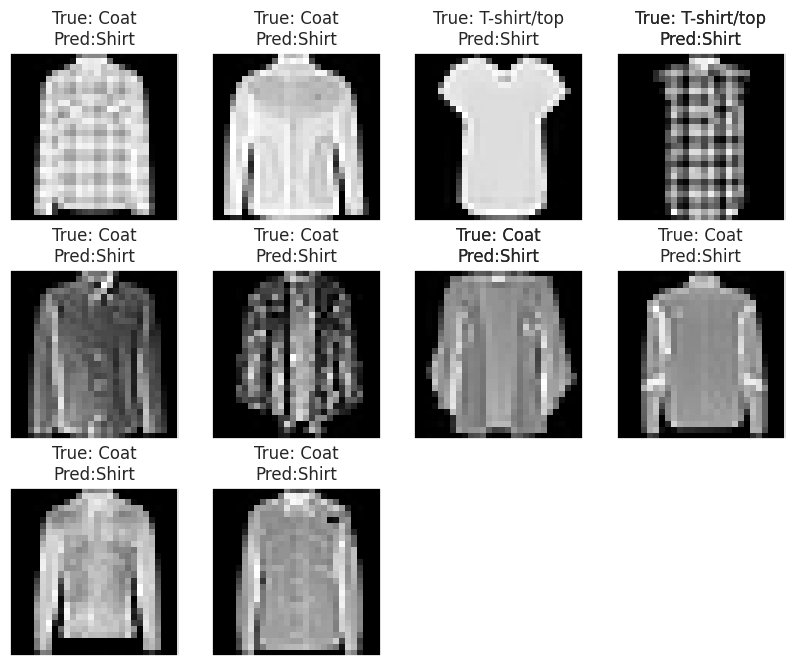

In [131]:
true_labels = list(map(lambda x: classes[np.argmax(x)], label[idx].tolist()))
pred_labels = list(map(lambda x: classes[np.argmax(x)], output[idx].tolist()))

imshow(
	input_list[idx][:,0],
	[f'True: {true}\nPred:{pred}' for true, pred in zip(true_labels, pred_labels)]
	, figsize=(10, 8)
)

We observe that the errors the model makes are:
<ul>
</ul>

### Conclusion
We were able to produce a model that keeps up with SOTA performance scores in the benchmark, roughly placing us around the <strong>10th position</strong> in <code>paperswithcode.com</code>.

I have learned a lot about computer vision models, and in particular the <strong>attention mechanism</strong>. I look forward to deploying the newly learned knowledge and techniques into my future notebooks.

Author: Kenneth Chen